In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install tensorflow

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as preprocess_DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt

# ---------------------------- 1. Image Loading Functions ----------------------------

def load_image_from_path(path, image_name):
    """
    Loads an image from the specified path.

    Args:
        path (str): Path to the image folder.
        image_name (str): Name of the image file to load.

    Returns:
        numpy.ndarray: Loaded image in RGB format.
    """
    image_path = os.path.join(path, image_name)
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image '{image_path}' not found.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB format
    return img

def load_images_from_folder(folder_path):
    """
    Loads all images from a folder using the load_image_from_path function.

    Args:
        folder_path (str): Path to the image folder.

    Returns:
        tuple: (list of images in RGB format, list of image names)
    """
    images = []
    image_names = []
    for image_name in os.listdir(folder_path):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            try:
                img = load_image_from_path(folder_path, image_name)
                images.append(img)
                image_names.append(image_name)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
    return images, image_names

# ---------------------------- 2. Patch Extraction Functions ----------------------------

def extract_patches(img, patch_size=224):
    """
    Splits the image into non-overlapping patches of size patch_size x patch_size.

    Args:
        img (numpy.ndarray): Input image array.
        patch_size (int): Size of each patch (default is 224).

    Returns:
        List[numpy.ndarray]: List of image patches.
    """
    h, w, c = img.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return patches

# ---------------------------- 3. Patch Saving Function ----------------------------

def save_patches(patches, save_folder, original_image_name, patch_size=224):
    """
    Saves image patches to the specified folder.

    Args:
        patches (list): List of image patches.
        save_folder (str): Directory to save patches.
        original_image_name (str): Original image name to prefix patch names.
        patch_size (int): Size of each patch (default is 224).

    Returns:
        None
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    base_name, ext = os.path.splitext(original_image_name)
    for idx, patch in enumerate(patches):
        patch_name = f"{base_name}_patch_{idx+1}{ext}"
        patch_path = os.path.join(save_folder, patch_name)
        patch_bgr = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving with cv2
        cv2.imwrite(patch_path, patch_bgr)

# ---------------------------- 4. LAB Color Extraction Function ----------------------------

def convert_to_lab_and_extract_channels(img_rgb):
    """
    Convert an RGB image to Lab color space and extract the L, a, and b channels.

    Args:
        img_rgb (numpy.ndarray): Input RGB image.

    Returns:
        tuple: (L_channel, a_channel, b_channel)
    """
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    L_channel = img_lab[:, :, 0]
    a_channel = img_lab[:, :, 1]
    b_channel = img_lab[:, :, 2]
    return L_channel, a_channel, b_channel

# ---------------------------- 5. Preparation for Pre-trained Models ----------------------------

def prepare_L_for_model(L_channel, model_type='densenet'):
    """
    Prepares the L channel image to be compatible with a specified pre-trained model.

    Args:
        L_channel (numpy.ndarray): Single-channel L image.
        model_type (str): Type of the model ('densenet' or 'resnet50').

    Returns:
        numpy.ndarray: Preprocessed image suitable for the specified model.
    """
    # Normalize L channel from [0, 100] to [0, 255]
    L_normalized = cv2.normalize(L_channel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    L_normalized = L_normalized.astype('uint8')

    # Stack L channel to make it 3-channel
    L_stacked = np.stack((L_normalized,) * 3, axis=-1)

    # Convert to float and expand dimensions to match model input
    L_stacked = image.img_to_array(L_stacked)
    L_stacked = np.expand_dims(L_stacked, axis=0)

    # Preprocess for the specified model
    if model_type == 'densenet':
        L_preprocessed = preprocess_DenseNet121(L_stacked)
    elif model_type == 'resnet50':
        L_preprocessed = preprocess_resnet50(L_stacked)
    else:
        raise ValueError("Unsupported model_type. Choose 'densenet' or 'resnet50'.")

    return L_preprocessed

# ---------------------------- 6. Feature Extractor Creation Function ----------------------------

def create_feature_extractor(model, layer_names):
    """
    Creates a model that outputs the activations from specified layers.

    Args:
        model (tf.keras.Model): The base model.
        layer_names (list): List of layer names to extract features from.

    Returns:
        tf.keras.Model: Model that outputs the specified layers.
    """
    outputs = [model.get_layer(name).output for name in layer_names]
    feature_extractor = Model(inputs=model.input, outputs=outputs)
    return feature_extractor

# ---------------------------- 7. Feature Extraction Function ----------------------------

def extract_features(feature_extractor, preprocessed_image):
    """
    Extracts features using the feature extractor model.

    Args:
        feature_extractor (tf.keras.Model): Model to extract features.
        preprocessed_image (numpy.ndarray): Preprocessed image.

    Returns:
        list: List of feature maps from specified layers.
    """
    features = feature_extractor.predict(preprocessed_image)
    return features

# ---------------------------- 8. Fusion Function ----------------------------

def fuse_two_features(feature_densenet, feature_resnet, fusion_type, conv_densenet, conv_resnet):
    """
    Fuses two feature maps using the specified fusion technique after aligning channel dimensions.

    Args:
        feature_densenet (numpy.ndarray): Feature map from DenseNet121.
        feature_resnet (numpy.ndarray): Feature map from ResNet50.
        fusion_type (str): Type of fusion ('average', 'max', 'concatenation').
        conv_densenet (tf.keras.layers.Conv2D): 1x1 convolution layer for DenseNet121.
        conv_resnet (tf.keras.layers.Conv2D): 1x1 convolution layer for ResNet50.

    Returns:
        numpy.ndarray: Fused feature map.
    """
    # Convert to tensors
    feature_densenet_tf = tf.convert_to_tensor(feature_densenet)
    feature_resnet_tf = tf.convert_to_tensor(feature_resnet)

    # Apply 1x1 convolution to align channel dimensions
    feature_densenet_conv = conv_densenet(feature_densenet_tf)
    feature_resnet_conv = conv_resnet(feature_resnet_tf)

    # Perform fusion
    if fusion_type == 'average':
        fused = (feature_densenet_conv + feature_resnet_conv) / 2
    elif fusion_type == 'max':
        fused = tf.maximum(feature_densenet_conv, feature_resnet_conv)
    elif fusion_type == 'concatenation':
        fused = tf.concat([feature_densenet_conv, feature_resnet_conv], axis=-1)
    else:
        raise ValueError("Unsupported fusion type. Choose 'average', 'max', or 'concatenation'.")

    # Convert back to NumPy array
    fused_np = fused.numpy()
    return fused_np

# ---------------------------- 9. Main Processing Pipeline ----------------------------

def main():
    # ------------------------ Configuration ------------------------
    # Paths
    input_folder = "/content/drive/MyDrive/ML Project Personal/Sample_image_5"          # Replace with your DIV2K dataset folder path
    patches_save_folder = "/content/drive/MyDrive/ML Project Personal/Sample_image_patches"        # Replace with your desired patches save folder path

    # Patch size
    patch_size = 224

    # Fusion type: 'average', 'max', or 'concatenation'
    fusion_type = 'average'  # Change as needed

    # ------------------------ Step 1: Load Images ------------------------
    print("Loading images...")
    images, image_names = load_images_from_folder(input_folder)
    print(f"Loaded {len(images)} images.")

    # ------------------------ Step 2: Extract and Save Patches ------------------------
    print("Extracting and saving patches...")
    for img, img_name in zip(images, image_names):
        patches = extract_patches(img, patch_size=patch_size)
        if patches:
            save_patches(patches, patches_save_folder, img_name, patch_size=patch_size)
    print("Patches extracted and saved.")

    # ------------------------ Step 3: Prepare Pre-trained Models ------------------------
    print("Loading pre-trained models...")

    # Load DenseNet121
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(patch_size, patch_size, 3))
    densenet_base.summary()  # Optional: Print model summary to find exact layer names

    # Define DenseNet121 layers corresponding to spatial dimensions
    densenet_layers = [
        'pool2_conv',   # ~56x56
        'pool3_conv',   # ~28x28
        'pool4_conv',   # ~14x14
         'conv5_block16_concat'    # ~7x7
    ]

    # Verify that these layers exist in the model
    densenet_layer_names = [layer.name for layer in densenet_base.layers]
    for layer in densenet_layers:
        if layer not in densenet_layer_names:
            raise ValueError(f"Layer '{layer}' not found in DenseNet121.")
    print("DenseNet121 layers verified.")

    densenet_feature_extractor = create_feature_extractor(densenet_base, densenet_layers)

    # Load ResNet50
    resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(patch_size, patch_size, 3))
    resnet50_base.summary()  # Optional: Print model summary to find exact layer names

    # Define ResNet50 layers corresponding to spatial dimensions
    resnet50_layers = [
        'conv2_block3_out',  # ~56x56
        'conv3_block4_out',  # ~28x28
        'conv4_block6_out',  # ~14x14
        'conv5_block3_out'   # ~7x7
    ]

    # Verify that these layers exist in the model
    resnet50_layer_names = [layer.name for layer in resnet50_base.layers]
    for layer in resnet50_layers:
        if layer not in resnet50_layer_names:
            raise ValueError(f"Layer '{layer}' not found in ResNet50.")
    print("ResNet50 layers verified.")

    resnet50_feature_extractor = create_feature_extractor(resnet50_base, resnet50_layers)

    print("Pre-trained models loaded.")

    # ------------------------ Step 4: Define 1x1 Convolution Layers for Fusion ------------------------
    print("Defining 1x1 convolution layers for fusion...")

    print("Defining 1x1 convolution layers for fusion...")

    # Define 1x1 conv layers for DenseNet121 with correct input channels
    dense_conv_layers = {
        'pool2_conv': Conv2D(
            filters=512, kernel_size=(1,1), padding='same', activation=None, name='dense_conv_pool2_conv'
        ),
        'pool3_conv': Conv2D(
            filters=1024, kernel_size=(1,1), padding='same', activation=None, name='dense_conv_pool3_conv'
        ),
        'pool4_conv': Conv2D(
            filters=2048, kernel_size=(1,1), padding='same', activation=None, name='dense_conv_pool4_conv'
        ),
        'conv5_block16_concat': Conv2D(
            filters=2048, kernel_size=(1,1), padding='same', activation=None, name='dense_conv_conv5_block16_concat'
        )
    }

    # Define 1x1 conv layers for ResNet50 with correct input channels
    resnet_conv_layers = {
        'conv2_block3_out': Conv2D(
            filters=512, kernel_size=(1,1), padding='same', activation=None, name='resnet_conv_conv2_block3_out'
        ),
        'conv3_block4_out': Conv2D(
            filters=1024, kernel_size=(1,1), padding='same', activation=None, name='resnet_conv_conv3_block4_out'
        ),
        'conv4_block6_out': Conv2D(
            filters=2048, kernel_size=(1,1), padding='same', activation=None, name='resnet_conv_conv4_block6_out'
        ),
        'conv5_block3_out': Conv2D(
            filters=2048, kernel_size=(1,1), padding='same', activation=None, name='resnet_conv_conv5_block3_out'
        )
    }

    print("1x1 convolution layers defined.")

    # ------------------------ Step 5: Process Each Patch ------------------------
    print("Processing patches for feature extraction and fusion...")
    fused_features_all = []  # List to store fused features for all patches

    # Get list of patch filenames
    patch_filenames = [f for f in os.listdir(patches_save_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    total_patches = len(patch_filenames)
    print(f"Total patches to process: {total_patches}")

    # Counter to limit detailed logging to the first N patches
    detailed_logging_limit = 5
    detailed_logging_count = 0

    # Remove manual build calls
    # Let Keras handle building upon first call

    for idx, patch_filename in enumerate(patch_filenames, start=1):
        patch_path = os.path.join(patches_save_folder, patch_filename)
        try:
            # Load patch
            patch_rgb = load_image_from_path(patches_save_folder, patch_filename)

            # Convert to LAB and extract channels
            L, a, b = convert_to_lab_and_extract_channels(patch_rgb)

            # Prepare L channel for DenseNet121
            L_densenet = prepare_L_for_model(L, model_type='densenet')

            # Prepare L channel for ResNet50
            L_resnet50 = prepare_L_for_model(L, model_type='resnet50')

            # Extract features from DenseNet121
            features_densenet = extract_features(densenet_feature_extractor, L_densenet)

            # Extract features from ResNet50
            features_resnet50 = extract_features(resnet50_feature_extractor, L_resnet50)

            # Initialize list to store fused features for current patch
            fused_features_patch = []

            # Fuse features for each spatial dimension
            for layer_idx in range(len(densenet_layers)):
                layer_densenet = densenet_layers[layer_idx]
                layer_resnet = resnet50_layers[layer_idx]

                feature_densenet = features_densenet[layer_idx]  # Shape: (1, H, W, D1)
                feature_resnet = features_resnet50[layer_idx]    # Shape: (1, H, W, D2)

                # Get corresponding 1x1 conv layers
                conv_densenet = dense_conv_layers[layer_densenet]
                conv_resnet = resnet_conv_layers[layer_resnet]

                # Perform fusion
                fused_feature = fuse_two_features(
                    feature_densenet,
                    feature_resnet,
                    fusion_type,
                    conv_densenet,
                    conv_resnet
                )

                fused_features_patch.append(fused_feature)

            # Append fused features for the current patch
            fused_features_all.append(fused_features_patch)

            # Detailed logging for the first few patches
            if detailed_logging_count < detailed_logging_limit:
                print(f"\nPatch {idx}: {patch_filename}")
                for layer_idx in range(len(densenet_layers)):
                    layer_name = densenet_layers[layer_idx]
                    fused_shape = fused_features_patch[layer_idx].shape
                    print(f"  Fused Layer {layer_idx+1} ({layer_name} + {resnet50_layers[layer_idx]}): {fused_shape}")
                detailed_logging_count += 1

            # Progress logging every 50 patches
            if idx % 50 == 0 or idx == total_patches:
                print(f"Processed {idx}/{total_patches} patches.")

        except Exception as e:
            print(f"Error processing patch {patch_filename}: {e}")

    print("\nFeature extraction and fusion completed.")

    # ------------------------ Step 6: Visualization of Fused Features ------------------------
    # Visualize fused features for the first patch
    if fused_features_all:
        first_fused_patch = fused_features_all[0]  # List of fused features at different levels
        spatial_resolutions = ['56x56', '28x28', '14x14', '7x7']
        num_levels = len(first_fused_patch)

        plt.figure(figsize=(20, 5))
        for idx in range(num_levels):
            fused_feature = first_fused_patch[idx]  # Shape: (1, H, W, D*)
            # Remove batch dimension
            fused_feature = np.squeeze(fused_feature, axis=0)
            # Compute the mean across channels for visualization
            fused_mean = np.mean(fused_feature, axis=-1)
            # Normalize for better visualization
            fused_mean_norm = cv2.normalize(fused_mean, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

            plt.subplot(1, num_levels, idx+1)
            plt.imshow(fused_mean_norm, cmap='viridis')
            plt.title(f'Fused Features at {spatial_resolutions[idx]}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No fused features extracted.")

    # ------------------------ Step 7: Save Fused Features (Optional) ------------------------
    # You can save the fused features to disk for later use.
    # Here's an example of how to save using NumPy's savez format.

    save_features = True  # Set to True to save features
    if save_features and fused_features_all:
        print("\nSaving fused features to disk...")
        # Organize features by spatial dimension
        # Initialize lists for each spatial dimension
        features_56x56 = []
        features_28x28 = []
        features_14x14 = []
        features_7x7 = []

        for fused in fused_features_all:
            features_56x56.append(fused[0])  # First layer: ~56x56
            features_28x28.append(fused[1])  # Second layer: ~28x28
            features_14x14.append(fused[2])  # Third layer: ~14x14
            features_7x7.append(fused[3])    # Fourth layer: ~7x7

        # Convert lists to NumPy arrays
        features_56x56 = np.array(features_56x56)
        features_28x28 = np.array(features_28x28)
        features_14x14 = np.array(features_14x14)
        features_7x7 = np.array(features_7x7)

        # Save to disk
        np.savez_compressed(
            '/content/drive/MyDrive/ML Project Personal/sample_fusion/fused_features.npz',
            features_56x56=features_56x56,
            features_28x28=features_28x28,
            features_14x14=features_14x14,
            features_7x7=features_7x7
        )
        print("Fused features saved as 'fused_features.npz'.")

Loading images...
Loaded 5 images.
Extracting and saving patches...
Patches extracted and saved.
Loading pre-trained models...


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

DenseNet121 layers verified.


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

ResNet50 layers verified.
Pre-trained models loaded.
Defining 1x1 convolution layers for fusion...
Defining 1x1 convolution layers for fusion...
1x1 convolution layers defined.
Processing patches for feature extraction and fusion...
Total patches to process: 288
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Patch 1: 0001_patch_1.png
  Fused Layer 1 (pool2_conv + conv2_block3_out): (1, 56, 56, 512)
  Fused Layer 2 (pool3_conv + conv3_block4_out): (1, 28, 28, 1024)
  Fused Layer 3 (pool4_conv + conv4_block6_out): (1, 14, 14, 2048)
  Fused Layer 4 (conv5_block16_concat + conv5_block3_out): (1, 7, 7, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step

Patch 2: 0001_patch_2.png
  Fused Layer 1 (pool2_conv + conv2_block3_out): (1, 56, 56, 512)
  Fused Layer 2 (pool3_conv + conv3_block4_out): (1, 28, 28, 1024)
  Fused Layer 3 (pool4_conv + conv4_block6_out): (1, 14, 14, 2048)
  Fused Layer 4 (conv5_block16_concat + conv5_block3_out):

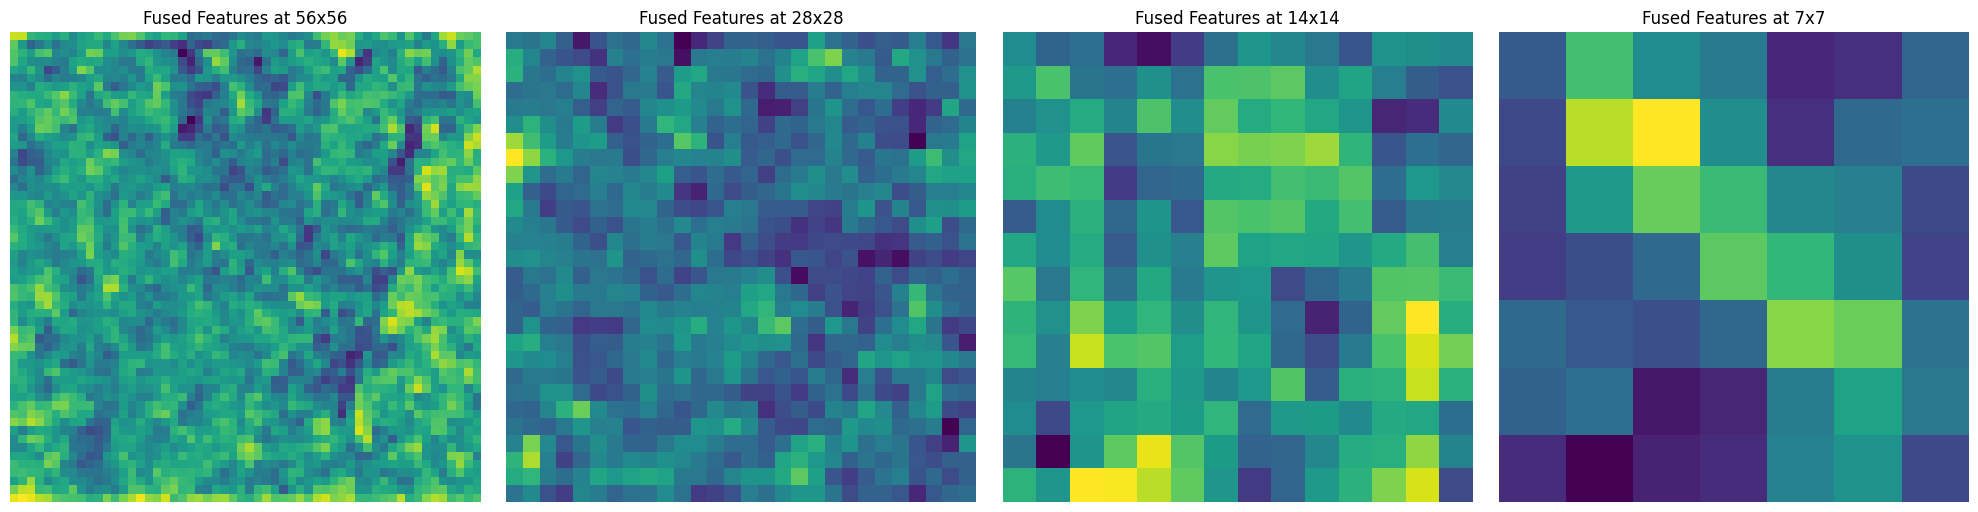


Saving fused features to disk...
Fused features saved as 'fused_features.npz'.


In [7]:
main()